# Project: Vehicle Detection and Tracking
The goal of this project is to implement a pipeline to detect and track vehicles at a video stream.

**Credits**: Some functions used in this project were provided by Udacity at the related lesson from the SDC ND. Many of them were tunned and updated to fit this training pipeline.

This notebook contains notes and resumes several other experiments done on the parameters used for the feature definition for the model training. 

### Rubric: Histogram of Oriented Gradients (HOG)
- **Criteria**: Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
- **Acceptance criteria**: Explanation given for methods used to extract HOG features, including which color space was chosen, which HOG parameters (orientations, pixels_per_cell, cells_per_block), and why.
- **Output**: **PASS**

> **HMA**: Regarding the color channel, the final choice for the project was YCrCb, which presented the best testing output when compared to other color spaces, both on single and all channels. The testing outputs for single channel and other color spaces varied from 85% on the worst cases to 99% for this feature selection.

> The use of HOG features was analogous to the canny edge detection used on the first project. As presented at the extracted images below in this notebook, the HOG extacted features abstract color information and result in a shape which reasembles the original object but abstract color and saturation features from the the object. The chosen values of orientation (9), pix_per_cell (8), cell_per_block (2) associated to all channels from YCrcb, work as a sort of subsample (resize from the original image) and fit well the training image size of 64x64. 

### Rubric: Histogram of Oriented Gradients (HOG)
- **Criteria**: Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
- **Acceptance criteria**: The HOG features extracted from the training data have been used to train a classifier, could be SVM, Decision Tree or other. Features should be scaled to zero mean and unit variance before training the classifier.
- **Output**: **PASS**

> **HMA**: For this project a SVM classifier proved good in accuracy for vehicle detection (very few frames with no detection after false positive filter) associated to a regular speed (more than 2 frames per second). 

> A data preparation / normalization is perfomed just before the training, with is done at the Training pipeline by the function "transform" from StandardScaler.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
%matplotlib inline

import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [1]:
# HMA: Data download 
# Check / Download / Unzip - Dataset

import os
path_DIR = './00-proj-datasetVehicle'
path_ZIP = './00-proj-datasetVehicle.zip'

if not(os.path.isdir(path_DIR)):
    if not(os.path.exists(path_ZIP)):
        # Download Dataset zipfile if DIR and ZIP file do not exist
        import urllib.request
        url = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip'
        print("Downloading Dataset...")
        urllib.request.urlretrieve(url, path_ZIP)
    
    # Unzip Dataset zipfile
    if (os.path.exists(path_ZIP)):
        print("Unzipping Dataset...")
        os.makedirs(path_DIR)
        import zipfile
        zip_ref = zipfile.ZipFile(path_ZIP, 'r')
        zip_ref.extractall(path_DIR)
        zip_ref.close()
print("Dataset ready.")

Dataset ready.


In [2]:
# HMA: Data download 
# Check / Download / Unzip - Dataset

import os
path_DIR = './00-proj-datasetNonVehicle'
path_ZIP = './00-proj-datasetNonVehicle.zip'

if not(os.path.isdir(path_DIR)):
    if not(os.path.exists(path_ZIP)):
        # Download Dataset zipfile if DIR and ZIP file do not exist
        import urllib.request
        url = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip'
        print("Downloading Dataset...")
        urllib.request.urlretrieve(url, path_ZIP)
    
    # Unzip Dataset zipfile
    if (os.path.exists(path_ZIP)):
        print("Unzipping Dataset...")
        os.makedirs(path_DIR)
        import zipfile
        zip_ref = zipfile.ZipFile(path_ZIP, 'r')
        zip_ref.extractall(path_DIR)
        zip_ref.close()
print("Dataset ready.")

Dataset ready.


In [5]:
def pltSingle(img, title, plot=True, axis_grid='off'):
    if plot == True:
        f, ax = plt.subplots(1,1)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis(axis_grid)
        plt.show()

In [17]:
def pltCompare(img1, title1, img2, title2, plot=True, axis_grid='off'):
    if plot == True:
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.imshow(img1)
        ax1.set_title(title1)
        ax1.axis(axis_grid)
        ax2.imshow(img2)
        ax2.set_title(title2)
        ax2.axis(axis_grid)
        plt.show()

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [8]:
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):#, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)#, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)#, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)#, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [9]:
# Define a function to return HOG features and visualization
def get_hog_features(img,
                     orient, 
                     pix_per_cell, 
                     cell_per_block,
                     vis=False, 
                     feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, 
                        color_space='RGB', 
                        spatial_size=(32, 32),
                        hist_bins=32, 
                        orient=9, 
                        pix_per_cell=8, 
                        cell_per_block=2, 
                        hog_channel=0,
                        spatial_feat=True, 
                        hist_feat=True, 
                        hog_feat=True,
                        vis=False):    
        #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            #print('converting to YCrCb')
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            hog_features = np.concatenate(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        if vis == True:
            _, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

## Parameters

In [12]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

## Pipeline Train Classifier 

In [13]:
datasetNonVehicle_DIR = './00-proj-datasetNonVehicle'
datasetVehicle_DIR = './00-proj-datasetVehicle'
notcars = []
cars = []
for fname in glob.iglob(datasetNonVehicle_DIR + '/**/*.png', recursive=True):
    notcars.append(fname)
    
for fname in glob.iglob(datasetVehicle_DIR + '/**/*.png', recursive=True):
    cars.append(fname)

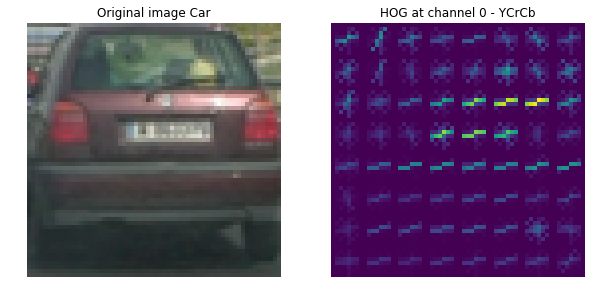

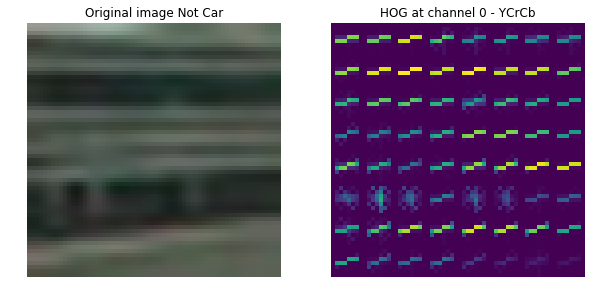

In [18]:
# Compare Original image and HOG output (single channel) for a car sample image
img_sample = cv2.imread(cars[0])
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
_, img_sample_hog = single_img_features(img_sample, 
                                        color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orient=orient, 
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, 
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, 
                                        hog_feat=hog_feat,
                                        vis=True)
pltCompare(img_sample, 'Original image Car', img_sample_hog, 'HOG at channel 0 - {}'.format(color_space))

# Compare Original image and HOG output (single channel) for a not car sample image
img_sample = cv2.imread(notcars[0])
img_sample = cv2.cvtColor(img_sample, cv2.COLOR_BGR2RGB)
_, img_sample_hog = single_img_features(img_sample, 
                                        color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orient=orient, 
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, 
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, 
                                        hog_feat=hog_feat,
                                        vis=True)
pltCompare(img_sample, 'Original image Not Car', img_sample_hog, 'HOG at channel 0 - {}'.format(color_space))

In [19]:
car_features = []
notcar_features = []

for fname in cars:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    car_features.append(single_img_features(img, 
                                        color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orient=orient, 
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, 
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, 
                                        hog_feat=hog_feat,
                                        vis=False))
for fname in notcars:
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    notcar_features.append(single_img_features(img, 
                                        color_space=color_space,
                                        spatial_size=spatial_size,
                                        hist_bins=hist_bins,
                                        orient=orient, 
                                        pix_per_cell=pix_per_cell,
                                        cell_per_block=cell_per_block,
                                        hog_channel=hog_channel, 
                                        spatial_feat=spatial_feat,
                                        hist_feat=hist_feat, 
                                        hog_feat=hog_feat,
                                        vis=False))

print(len(car_features))
print(len(notcar_features))

8792
8968


In [35]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
4.66 Seconds to train SVC...
Test Accuracy of SVC =  0.9932


In [36]:
import pickle

svc_params_dict = {'svc':svc, 
                   'scaler':X_scaler,
                   'color_space':color_space,
                   'orient':orient, 
                   'pix_per_cell':pix_per_cell, 
                   'cell_per_block':cell_per_block,
                   'hog_channel':hog_channel,
                   'spatial_size':spatial_size, 
                   'hist_bins':hist_bins,
                   'spatial_feat':spatial_feat,
                   'hist_feat':hist_feat,
                   'hog_feat':hog_feat}
pickle.dump(svc_params_dict, open("20-output-classifier.p", "wb" ) )